In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps, isotonic

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('yacht')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
x_eval = x_train[180:-1, ]
y_eval = y_train[180:-1, ]
x_train = x_train[0:180, ]
y_train = y_train[0:180, ]

In [5]:
nllk_model = isotonic.train_model_nllk(x_train, y_train, n_epoch = 2000, hidden_layers = [30, 30], learning_rate = 0.001, exp_decay = .998)

initial loss:  1.4081166982650757
final loss:  -7.7617669105529785


In [6]:
isotonic_model = isotonic.train_isotonic_regression(nllk_model, x_eval, y_eval)

In [7]:
isotonic_model.transform(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9]))

array([0.2708372 , 0.34660244, 0.38633305, 0.47393012, 0.48577747,
       0.5009608 , 0.57231694, 0.63767225, 0.67035854], dtype=float32)

End2end test MAPE:  0.3935814
End2end test RMSE:  1.0768807
End2end test NLLK:  9.40322
End2end test CRPS:  tensor(0.5625)


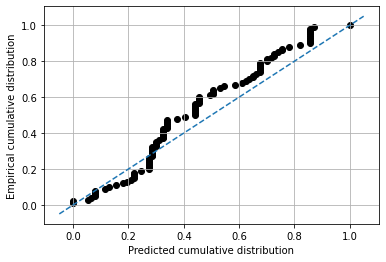

End2end test calibration error when step size is 0.001:  6.639311097992919
End2end test calibration error when step size is 0.01:  0.6616520492494522
End2end test calibration error when step size is 0.1:  0.05226007758475294


In [8]:
mean_pred, var_pred = nllk_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
pcdf = isotonic_model.transform(pcdf)
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))